In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from PyQt5.QtCore.QByteArray import length
from numpy.ma.core import shape

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ModuleNotFoundError: No module named 'PyQt5.QtCore.QByteArray'; 'PyQt5.QtCore' is not a package

In [2]:
RANDOM_SEED = 8924
az.style.use("arviz-darkgrid")

In [3]:
try:
    srrs2 = pd.read_csv(os.path.join("..", "data", "srrs2.dat"))
except FileNotFoundError:
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

In [4]:
try:
    cty = pd.read_csv(os.path.join("..", "data", "cty.dat"))
except FileNotFoundError:
    cty = pd.read_csv(pm.get_data("cty.dat"))

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.map(str.strip)
county, mn_counties = srrs_mn.county.factorize()
srrs_mn["county_code"] = county
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

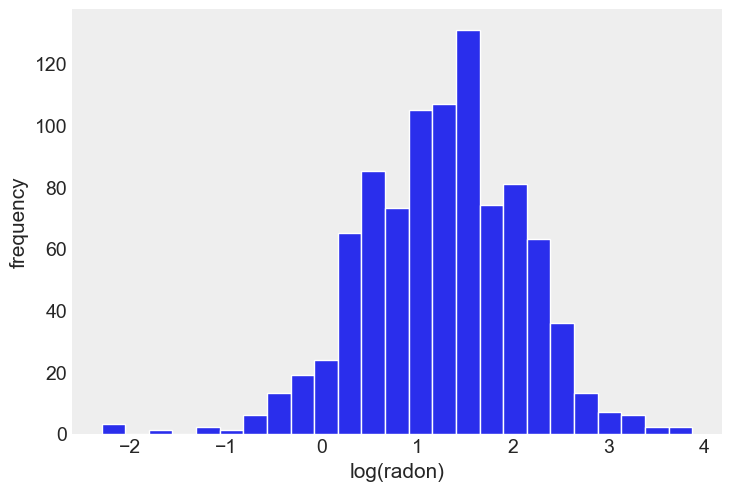

In [7]:
srrs_mn.log_radon.hist(bins=25, grid=False)
plt.xlabel("log(radon)")
plt.ylabel("frequency");

In [8]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as varying_intercept_slope:
    floor_idx = pm.MutableData("floor_idx", floor_measure, dims="obs_id")
    county_idx = pm.MutableData("county_idx", county, dims="obs_id")

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.Exponential("sigma_b", 1)

    # Random intercepts
    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="county")
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Exponential("sigma_y", 1)

    # Expected value
    y_hat = alpha[county_idx] + beta[county_idx] * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon, dims="obs_id")

F:\anaconda\envs\pymc_env\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, alpha, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


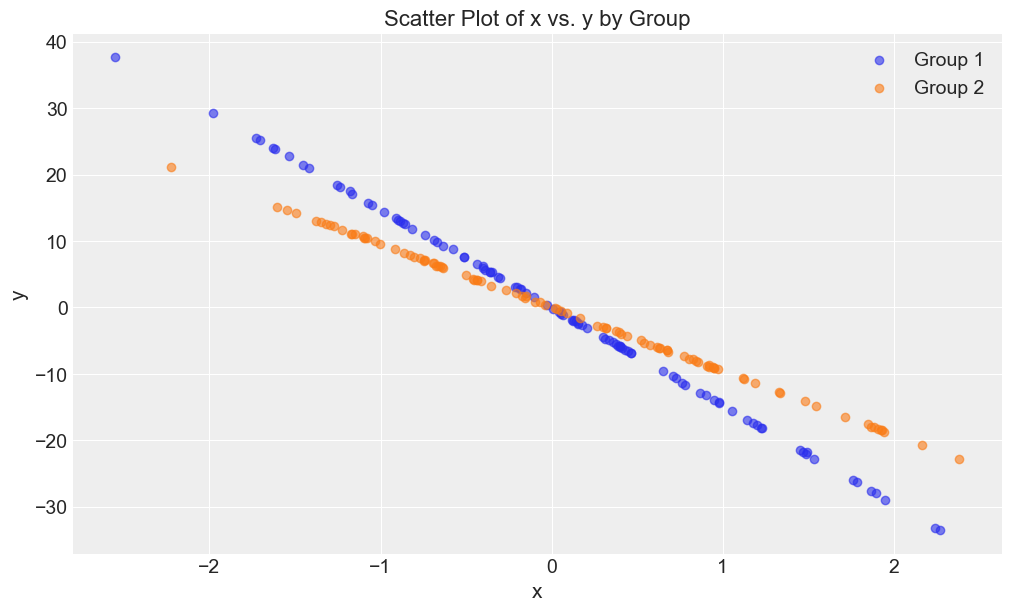

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Number of samples and number of components
n_samples = 200
num_components = 2

# Generate the predictor variable x
x = np.random.normal(0, np.sqrt(1), n_samples)

# Initialize the response variable y
y = np.zeros(n_samples)

# Generate random betas (coefficients)
betas = np.random.normal(0, 40, num_components)

# Create group labels
groups = np.zeros(n_samples)

# Apply the different betas for every 100 samples and add random noise
for i in range(num_components):
    start_idx = i * 100
    end_idx = (i + 1) * 100
    y[start_idx:end_idx] = x[start_idx:end_idx] * betas[i] + np.random.normal(0, 0.1, 100)
    groups[start_idx:end_idx] = i

# Create a scatter plot, color-coded by group
plt.figure(figsize=(10, 6))
for i in range(num_components):
    group_idx = groups == i
    plt.scatter(x[group_idx], y[group_idx], label=f'Group {i+1}', alpha=0.6)

# Add plot labels and legend
plt.title('Scatter Plot of x vs. y by Group')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


# Gaussian Mixture Regression with GMR

In [4]:
import numpy as np
from gmr import GMM

# Your dataset as a NumPy array of shape (n_samples, n_features):
X = np.random.randn(100, 2)

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)

# Estimate GMM with expectation maximization:
X_sampled = gmm.sample(100)

# Make predictions with known values for the first feature:
x1 = np.random.randn(20, 1)
x1_index = [0]
x2_predicted_mean = gmm.predict(x1_index, x1)

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\S'
<>:43: SyntaxWarning: invalid escape sequence '\m'
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:42: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
C:\Users\10191\AppData\Local\Temp\ipykernel_18556\211232875.py:43: SyntaxWarning: invalid escape sequence '\m'
  "\mathcal{N}_{k, Y|X}$")


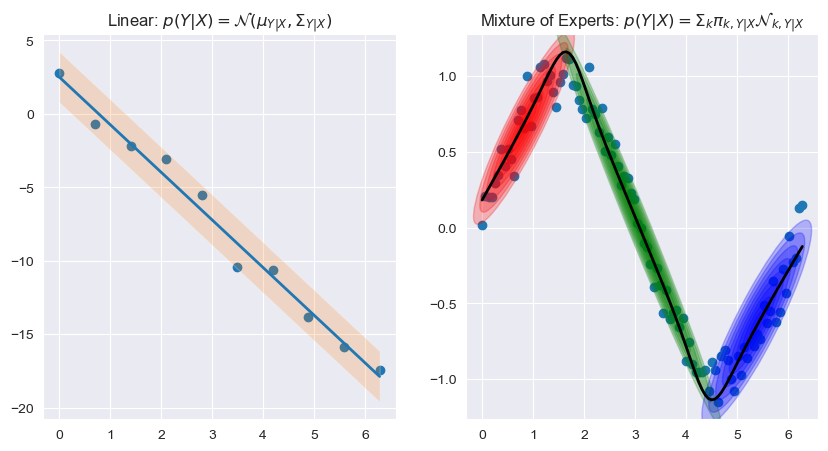

In [3]:
from sklearn.mixture import GaussianMixture
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 10
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 2 * np.pi, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

# Bayesian Gaussian Mixture Regression with PyMC3

In [2]:
import os
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Bayesian Mixtures of Linear Regression Models 
Here we define the model $Y_{ij}=X_{ij}\beta_j + \epsilon_{ij}$ 


In [7]:
RANDOM_SEED = 42
k = 2

In [ ]:
# Generate data
def GenerateData(n_compo = list(100), N_components=2):
    # Parameters for the two linear regression models
    b = list()
    a = list()
    for i in range(N_components):
        b.append(np.random.uniform(0, 50, size=(1, 1)))  # slopes
        a.append(np.random.uniform(-10, 10, size=(1, 1)))   # intercepts
    sigma = 0.01   # standard deviation for the noise
    X = list()
    for i in range(N_components):
        X.append(np.random.uniform(-10, 10, size=(n_compo[i], 1)))
    e = list()
    for i in range(N_components):
        e.append(np.random.normal(0, sigma, size=(n_compo[i], 1)))
    Y = list()
    for i in range(N_components):
        Y.append(b[i] * X[i] + a[i] + e[i])
    X = np.vstack(X)
    Y = np.vstack(Y).ravel()
    return X, Y

n_compo = [100, 100, 100]


In [3]:
# Dataset 1
df = pd.read_csv('mixture.csv')
X = df['X'].values[:, None]
Y = df['Y'].values
 # Set k to small value for testing

In [8]:
# Dataset 2
# Another example of linear regression model with two components
# Update n to 1000 for the new data generation
n = 1000
N_components = 4
# Parameters for the two linear regression models
b = [5, 10, 20, 25]  # slopes
a = [0, 10, 15, 25]   # intercepts
n = 100       # number of samples
sigma = 0.01   # standard deviation for the noise
k=4
X = list()
for i in range(N_components):
    X.append(np.random.uniform(-10+10*(i-1), 10+10*(i-1), size=(n, 1)))
# Generate X values for the first 500 samples and second 500 samples separately
#X1 = np.random.uniform(-10, 10, size=(100, 1))
#X2 = np.random.uniform(-10, 10, size=(100, 1))
#X3 = np.random.uniform(-10, 10, size=(100, 1))
#X4 = np.random.uniform(-10, 10, size=(100, 1))

# Generate noise
e = list()
for i in range(N_components):
    e.append(np.random.normal(0, sigma, size=(n, 1)))
#e1 = np.random.normal(0, sigma, size=(100, 1))
#e2 = np.random.normal(0, sigma, size=(100, 1))
#e3 = np.random.normal(0, sigma, size=(100, 1))
#e4 = np.random.normal(0, sigma, size=(100, 1))
Y = list()
for i in range(N_components):
    Y.append(b[i] * X[i] + a[i] + e[i])
# Generate Y values based on two different linear regressions
X = np.vstack(X)
Y = np.vstack(Y).ravel()
 
#Y1 = b[0] * X1 + a[0] + e1
#Y2 = b[1] * X2 + a[1] + e2
#Y1 =  b[0] + e1
#Y2 =  b[1] + e2

# Combine the data into a single DataFrame
#X = np.vstack([X1, X2])
#Y = np.vstack([Y1, Y2]).ravel()

In [9]:
# Dataset 3
n_samples = 100
random_state = np.random.RandomState(42)
X = np.ndarray((n_samples, 2))
X = np.linspace(0, 2 * np.pi, n_samples)
Y = np.sin(X) + random_state.randn(n_samples) * 0.1
k = 3


The model is defined as follows:
$$\pi_i \sim Dirichlet(k)$$
$$\alpha_i \sim Normal(0, 100)$$
$$\beta_i \sim Normal(0, 100)$$
$$\sigma_i \sim HalfCauchy(5)$$

$$\mu_{i} = \alpha_{i} + \beta_{i} X$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [8]:
#With dirichlet distribution
with pm.Model() as Mixture_regression1:
    # Priors for weight parameter
    π = pm.Dirichlet('π', np.array([1]*k), initval=np.ones(k)/k) # Component weights
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    σ  = pm.HalfCauchy('σ', 5, shape=k)  #Noise
    
    mu = α + β*X
    #try other likelihood
    likelihood = pm.NormalMixture('likelihood', π, mu, sigma=σ, observed=Y)
    trace = pm.sample(tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 42900
Interrupted at 42,899 [21%]: Average Loss = 4,047.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [π, α, β, σ]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1059 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The model is defined as follows:
$$ \alpha \sim Gamma(1,5)$$
$$ \beta \sim Beta(1, \alpha)$$
$$ \pi_i \sim \beta_i\Pi_{j=1}^{i-1}(1-\beta_j)$$

$$a_i \sim N(0,100)$$
$$b_i \sim N(0,100)$$
$$\mu_{i} = a_{i} + b_{i} X$$
$$\sigma_i \sim HalfCauchy(1)$$
$$Y|X, \alpha, \beta, \sigma, \pi \sim \Sigma_{i}^{k}\pi_i Normal(\mu_i, \sigma_i)$$

In [9]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [10]:
def reparameterize(beta):
    return beta / beta.sum()

In [17]:
#Dirichlet Process Gaussian Mixture Model
#still debugging
N = Y.shape[0]
with pm.Model(coords={"component": np.arange(k),"obs_id": np.arange(N)}) as Mixture_regression2:
    # Priors for weight parameter
    alpha = pm.Gamma("alpha", 1.0, 5.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component") # Generate beta values
    π = pm.Deterministic("π", stick_breaking(beta), dims="component")  # Component weights
    π1 = pm.Deterministic("π1", reparameterize(π), dims="component")  # Component weights
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=100, shape=(1, k)) #Intercept
    β = pm.Normal('β', mu=0, sigma=100, shape=(1, k))
    
    σ  = pm.HalfCauchy('σ', 1, shape=k)  #Noise
    
    mu = α + β*X
    #mu = α    
    likelihood = pm.NormalMixture('likelihood', π1, mu, sigma=σ, observed=Y)
    trace = pm.sample(
            tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,
        )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 23500
Interrupted at 23,499 [11%]: Average Loss = 9.1461e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, α, β, σ]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1048 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [18]:
def summary(trace, model):
    print(az.summary(trace, var_names=["α", "β", "π", "σ"]))
    az.plot_trace(trace)
    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    az.plot_posterior(trace, var_names=["α", "β", "σ", "π"])
    fig, ax = plt.subplots(figsize=(8, 6))

    plot_w = np.arange(k) + 1
    
    ax.bar(plot_w - 0.5, trace.posterior["π"].mean(("chain", "draw")), width=1.0, lw=0)
    
    ax.set_xlim(0.5, k)
    ax.set_xlabel("Component")
    
    ax.set_ylabel("Posterior expected mixture weight");


            mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]    1.233    2.487  -1.374    5.830      1.231    0.941       5.0   
α[0, 1]    2.502    4.330  -0.001   10.002      2.156    1.651       7.0   
α[0, 2]    4.546    3.669   0.001   10.002      1.822    1.397       5.0   
α[0, 3]    3.939    3.666   0.438   10.004      1.819    1.397       5.0   
β[0, 0]   14.838    9.853   2.828   25.326      4.906    3.756       5.0   
β[0, 1]    6.250    2.165   5.000   10.000      1.078    0.826       7.0   
β[0, 2]   10.805    8.537   2.617   25.194      4.249    3.255       5.0   
β[0, 3]   10.116    6.871   2.468   25.169      3.400    2.600       4.0   
π[0]       0.328    0.290   0.029    0.763      0.144    0.110       4.0   
π[1]       0.226    0.020   0.186    0.264      0.007    0.005       8.0   
π[2]       0.242    0.170   0.009    0.512      0.085    0.065       4.0   
π[3]       0.165    0.178   0.000    0.452      0.089    0.068       5.0   
σ[0]     150

Sampling: [likelihood]


Output()

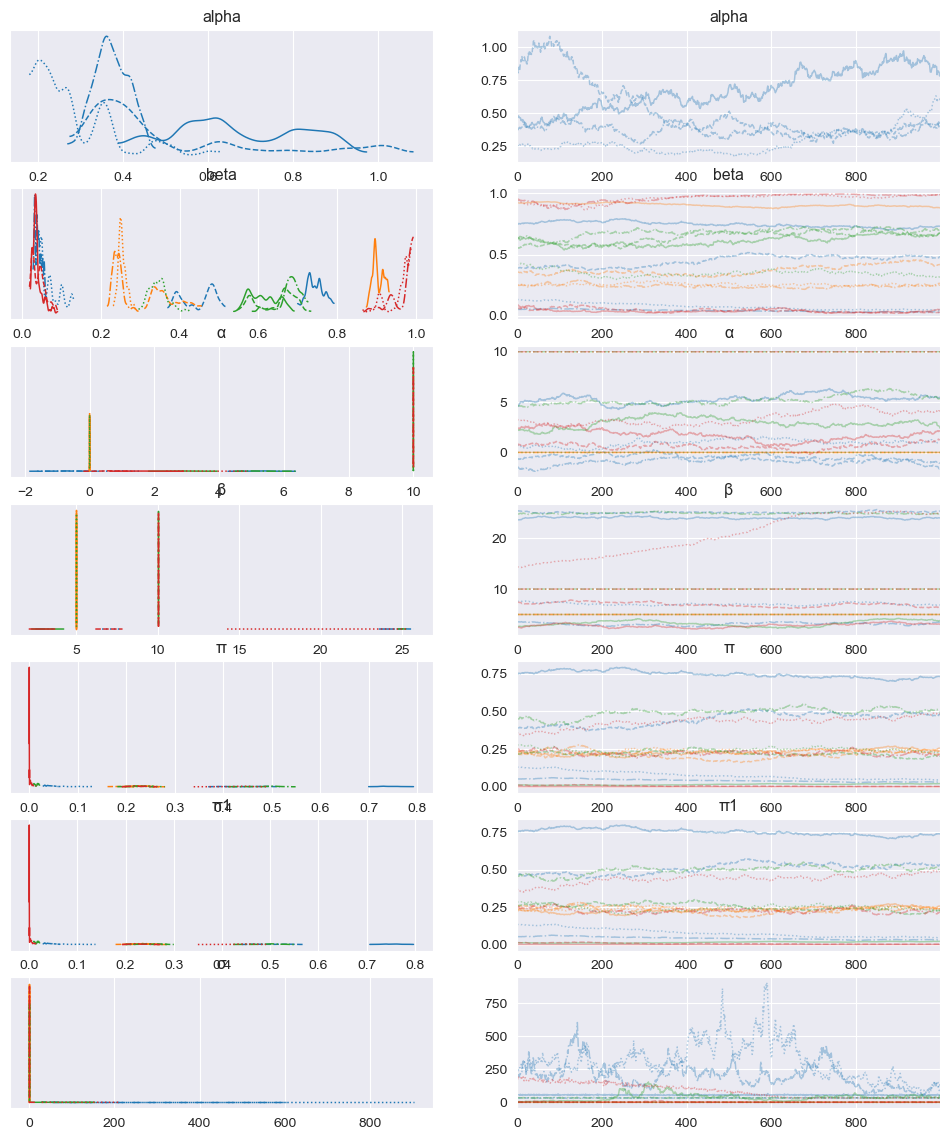

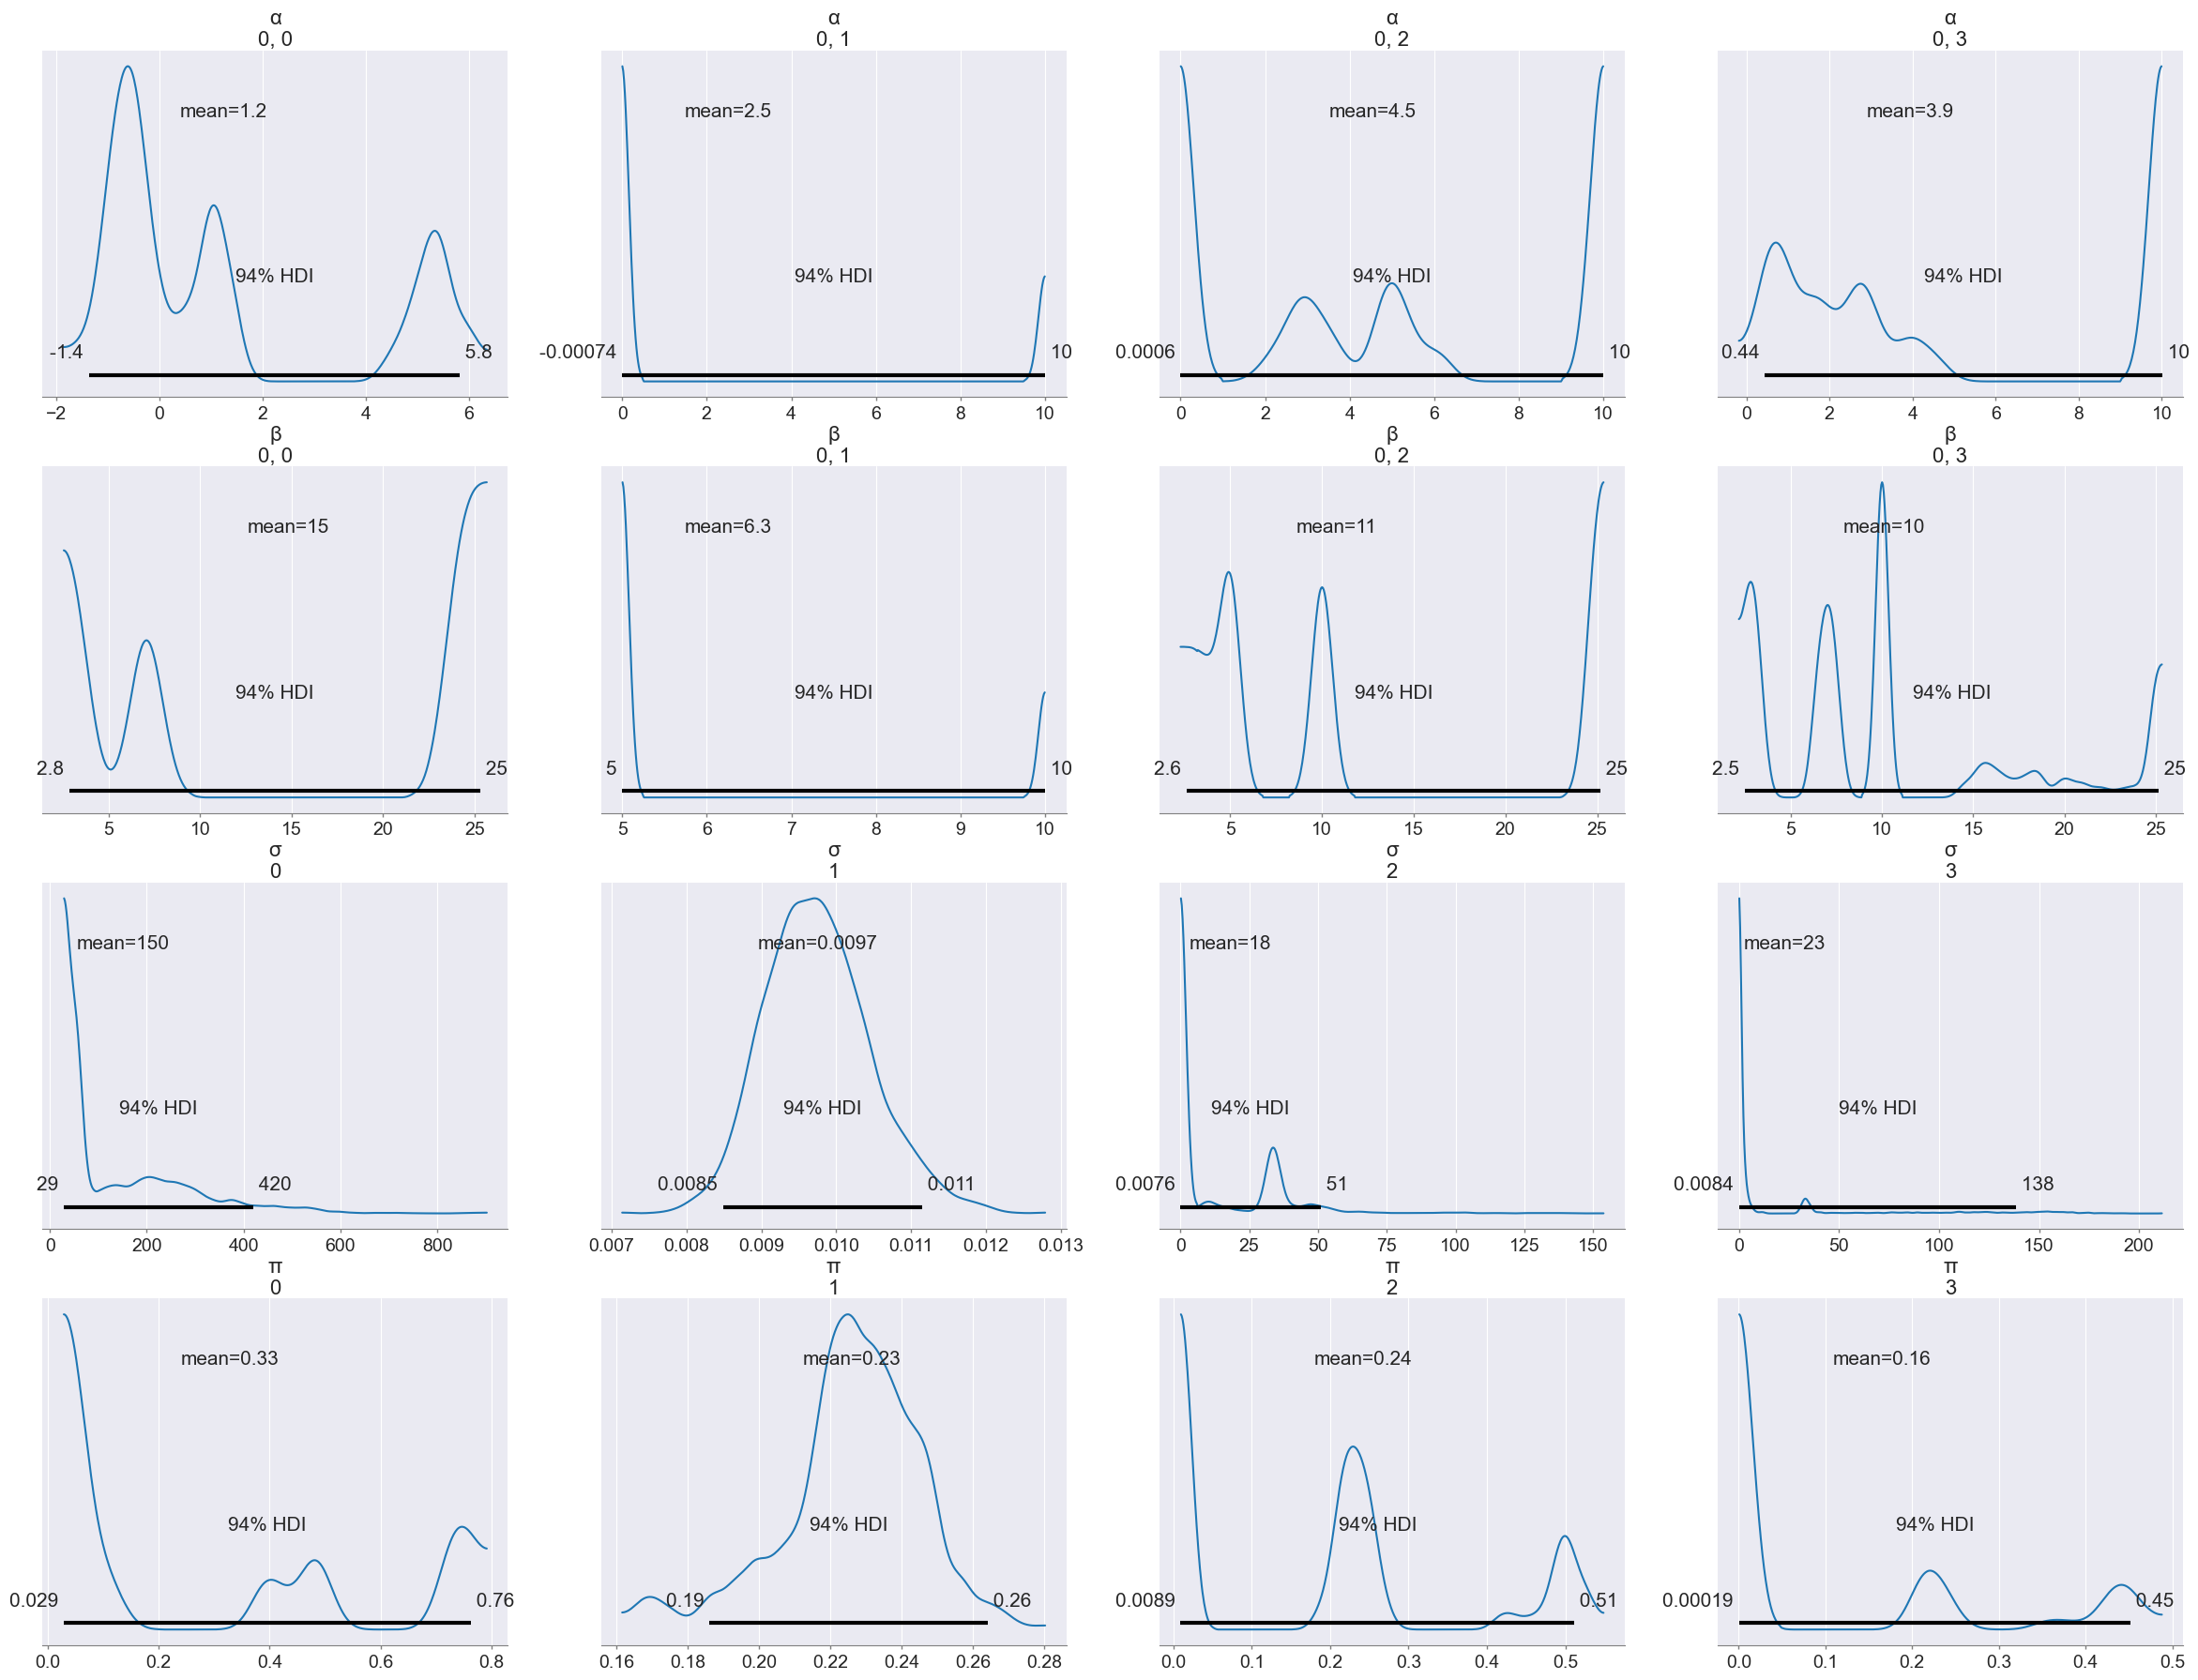

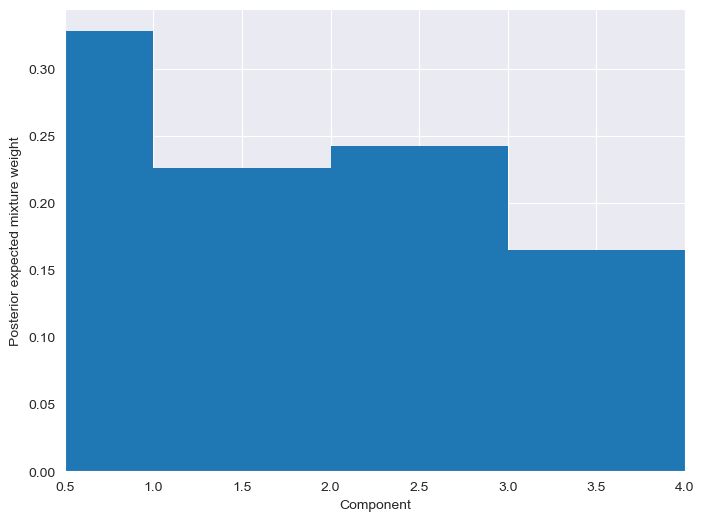

In [19]:
summary(trace, Mixture_regression2)

array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'π'}>, <Axes: title={'center': 'π'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

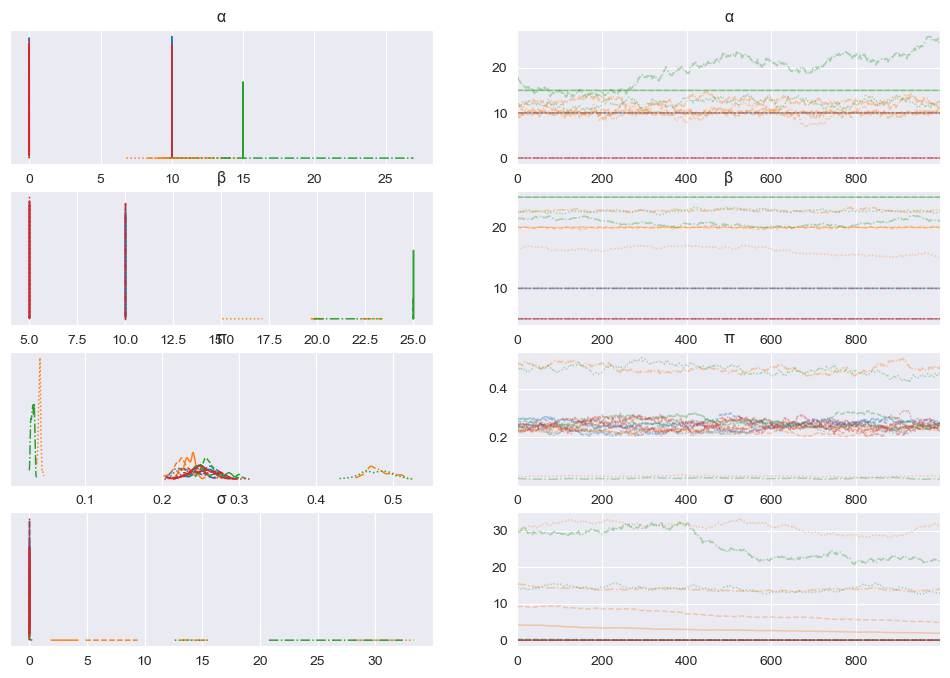

In [9]:
az.plot_trace(trace) 

In [10]:
with Mixture_regression1:
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

Sampling: [likelihood]


Output()

In [11]:
summary = az.summary(trace, var_names=['α', 'β', 'π', 'σ'])
print(summary)

           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]   7.500   4.331  -0.001   10.002      2.157    1.651       7.0   
α[0, 1]  10.830   1.376   8.799   13.604      0.528    0.400       8.0   
α[0, 2]  15.448   3.171  10.987   22.724      1.461    1.105       5.0   
α[0, 3]   2.500   4.330  -0.001   10.001      2.157    1.651       7.0   
β[0, 0]   8.750   2.165   5.000   10.000      1.078    0.826       7.0   
β[0, 1]  19.755   2.349  15.499   23.073      1.164    0.891       5.0   
β[0, 2]  23.379   1.784  20.317   25.010      0.878    0.672       5.0   
β[0, 3]   6.250   2.165   5.000   10.000      1.078    0.826       7.0   
π[0]      0.246   0.019   0.212    0.276      0.007    0.005       8.0   
π[1]      0.246   0.158   0.036    0.496      0.078    0.060       5.0   
π[2]      0.259   0.159   0.028    0.494      0.079    0.060       5.0   
π[3]      0.250   0.018   0.220    0.286      0.003    0.002      35.0   
σ[0]      0.010   0.001   0.009    0.0

array([[<Axes: title={'center': 'α\n0, 0'}>,
        <Axes: title={'center': 'α\n0, 1'}>,
        <Axes: title={'center': 'α\n0, 2'}>,
        <Axes: title={'center': 'α\n0, 3'}>],
       [<Axes: title={'center': 'β\n0, 0'}>,
        <Axes: title={'center': 'β\n0, 1'}>,
        <Axes: title={'center': 'β\n0, 2'}>,
        <Axes: title={'center': 'β\n0, 3'}>],
       [<Axes: title={'center': 'σ\n0'}>,
        <Axes: title={'center': 'σ\n1'}>,
        <Axes: title={'center': 'σ\n2'}>,
        <Axes: title={'center': 'σ\n3'}>],
       [<Axes: title={'center': 'π\n0'}>,
        <Axes: title={'center': 'π\n1'}>,
        <Axes: title={'center': 'π\n2'}>,
        <Axes: title={'center': 'π\n3'}>]], dtype=object)

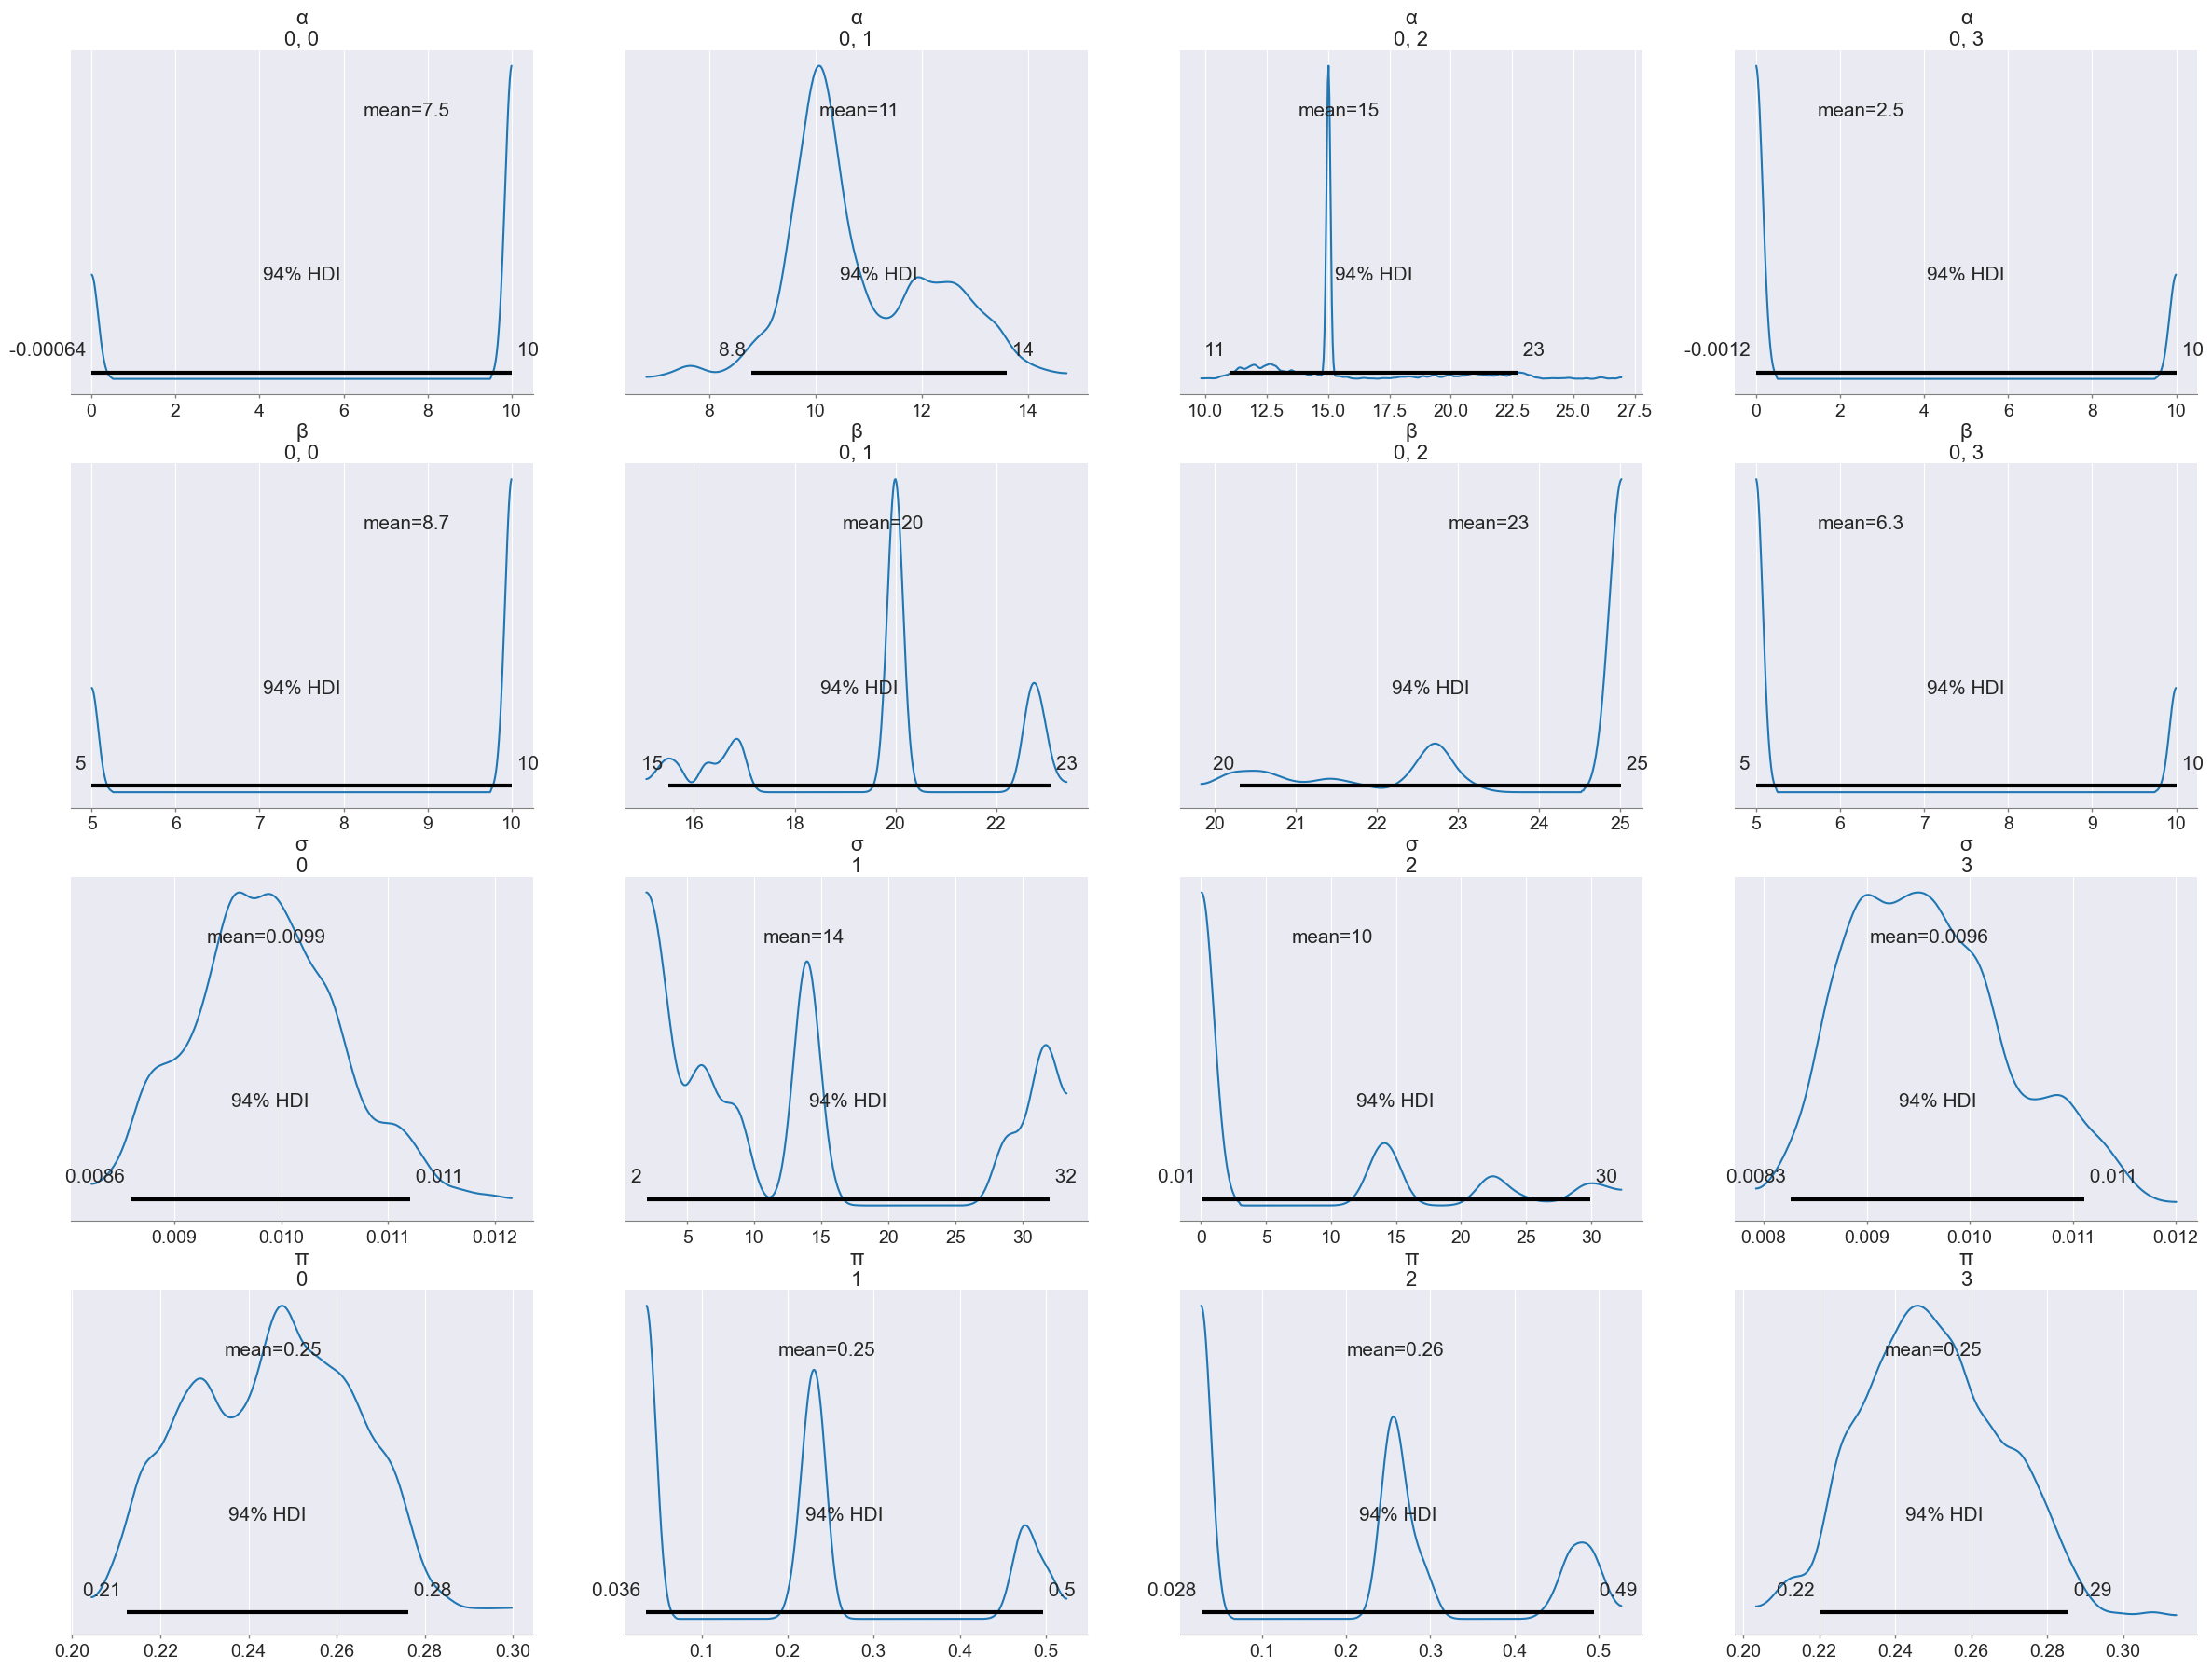

In [12]:
az.plot_posterior(trace, var_names=["α", "β", "σ", "π"])

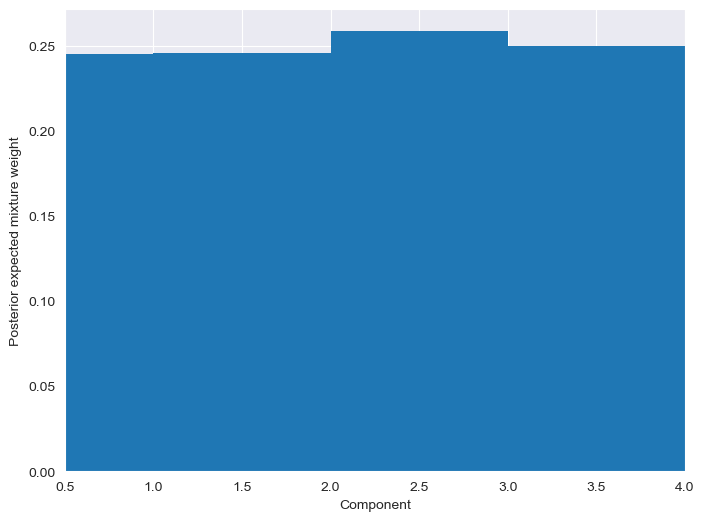

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(k) + 1

ax.bar(plot_w - 0.5, trace.posterior["π"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, k)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");